# Feature importance plot

Creates figures representing the feature importance of the FTC, nFTC and general random forest experiments.

## Data loading

Loads the `.txt` files outputted by the experiment notebooks.

In [56]:
%reload_ext autoreload
%autoreload 2

import python_proj.utils.exp_utils as exp_utils

base_path = exp_utils.BASE_PATH
file_name = "dataset_transformed"

experiments = ["rf_ftc", "rf_nftc", "rf_full"]

figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

data = {}
for experiment in experiments:
    data_file = f"{figure_base_path}/{experiment}/feature_importance.txt"
    print(f'Loading from "{data_file}".')
    with open(data_file, "r", encoding="utf-8") as input_file:
        data[experiment] = input_file.read()

Loading from "/workspaces/msc_thesis/data//figures/modelling/dataset_transformed//rf_ftc/feature_importance.txt".
Loading from "/workspaces/msc_thesis/data//figures/modelling/dataset_transformed//rf_nftc/feature_importance.txt".
Loading from "/workspaces/msc_thesis/data//figures/modelling/dataset_transformed//rf_full/feature_importance.txt".


### Name mappings

Translates experimental names to human readable ones.

In [57]:
# Feature mapping
name_mapping = {
    "ln(1 + ControlPullRequestLifeTimeInMinutes)": "PR lifetime",
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)": "Integrator exp.",
    "IntraProjectSubmitterPullRequestSuccessRate": "Intra. PR merge rate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)": "Intra. PR count",
    "ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)": "Node centrality",
    "ControlIntegratedBySameUser": "PR is self-integrated",
    "ln(1 + ControlNumberOfCommitsInPullRequest)": "PR commit count",
    "EcosystemExperienceSubmitterPullRequestSuccessRate": "Eco. PR merge rate",
    "ControlPullRequestHasComments": "PR has comments",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)": "Intra. PR comments",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)": "Intra. Issue Comments",
    "ln(1 + EcosystemLinkIntensity)": "Link strength",
    "ln(1 + EcosystemExperienceSubmitterIssueCommentCount)": "Eco. issue comments",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount)": "Non-dep. issue comments",
    "SubmitterIsFirstTimeContributor": "First-time contr.",
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)": "Eco. PR count",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)": "Eco. PR comments",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)": "Non-dep. PR comments",
    "ControlHasHashTagInDescription": "PR contains '#'",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)": "Non-dep. issues",
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)": "Intra. issues",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)": "Eco. issues",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)": "Non-dep. PR count",
    "ControlPullRequestHasCommentByExternalUser": "PR has com. ext. contr.",
    "NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate": "Non-dep PR merge rate",
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)": "Downstr. PR comments",
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)": "Downstr. PR count",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)": "Downstr. issue comments",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)": "Upstr. issue comments",
    "DependencyEcosystemExperienceSubmitterPullRequestSuccessRate": "Downstr. PR merge rate",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)": "Upstr. PR comments",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)": "Upstr. PR count",
    "InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate": "Upstr. PR merge rate",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)": "Downstr. issues",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)": "Upstr. issues",
}

### Data parsing

In [58]:
from wmutils.collections.safe_dict import SafeDict

# parses the entries into separate dicts.
importances = SafeDict(default_value=dict)
clean_importances = SafeDict(default_value=dict)

for label, scores in data.items():
    for entry in scores.split("\n"):
        elements = entry.split(":")
        field = elements[0].strip()
        if len(field) == 0:
            continue
        renamed_field = name_mapping[field]
        score = float(elements[1].strip())
        importances[label][renamed_field] = score
        clean_importances[label][field] = score

full_importances = importances["rf_full"]
ftc_importances = importances["rf_ftc"]
non_ftc_importances = importances["rf_nftc"]

## Feature group comparison

In [59]:
group_to_feature_prefix = {""}

exp_types = [
    "{group}SubmitterPullRequestSuccessRate",
    "ln(1 + {group}SubmitterPullRequestSubmissionCount)",
    "ln(1 + {group}SubmitterPullRequestCommentCount)",
    "ln(1 + {group}SubmitterIssueSubmissionCount)",
    "ln(1 + {group}SubmitterIssueCommentCount)",

]

groups = [
    "IntraProject",
    "EcosystemExperience",
    "NonDependencyEcosystemExperience",
    "DependencyEcosystemExperience",
    "InversedDependencyEcosystemExperience",
]

In [60]:
from typing import Dict


def compare_feature_groups(
    importances: Dict[str, float], group_a: str, group_b: str
) -> None:
    """
    Returns percentage of group a features
    that score above group b features.
    """

    higher = 0
    total = 0

    for exp_type in exp_types:
        field_a = exp_type.format(group=group_a)
        field_b = exp_type.format(group=group_b)

        if field_a in importances and field_b in importances:
            if importances[field_a] != 0 and importances[field_b] != 0:
                a_is_greater = importances[field_a] > importances[field_b]
                # print(f"{name_mapping[field_a]} ({importances[field_a]:.3f}) > {name_mapping[field_b]} ({importances[field_b]:.3f}) = {a_is_greater}")
                if a_is_greater:
                    higher += 1

                total += 1

    rat = higher / total * 100
    print(f"{group_a} > {group_b}: {higher} / {total} = {rat:.2f}%")

In [61]:
def compare_feature_groups_in_model(model: str):
    print(f"{model=}")
    # Compare Ecosystem with Intra
    compare_feature_groups(
        clean_importances[model], "IntraProject", "EcosystemExperience"
    )

    #  Compare Upstream with non-dependency
    compare_feature_groups(
        clean_importances[model],
        "NonDependencyEcosystemExperience",
        "InversedDependencyEcosystemExperience",
    )

    # Compare downstream with non-dependency
    compare_feature_groups(
        clean_importances[model],
        "NonDependencyEcosystemExperience",
        "DependencyEcosystemExperience",
    )

    #  Compare Upstream with intra
    compare_feature_groups(
        clean_importances[model],
        "IntraProject",
        "InversedDependencyEcosystemExperience",
    )

    # Compare downstream with intra
    compare_feature_groups(
        clean_importances[model],
        "IntraProject",
        "DependencyEcosystemExperience",
    )

    # Compare non-dependency with intra
    compare_feature_groups(
        clean_importances[model],
        "IntraProject",
        "NonDependencyEcosystemExperience",
    )

    # Compare upstream with downstream
    compare_feature_groups(
        clean_importances[model],
        "DependencyEcosystemExperience",
        "InversedDependencyEcosystemExperience",
    )

    print()

In [62]:
compare_feature_groups_in_model("rf_full")
compare_feature_groups_in_model("rf_ftc")
compare_feature_groups_in_model("rf_nftc")

model='rf_full'
IntraProject > EcosystemExperience: 5 / 5 = 100.00%
NonDependencyEcosystemExperience > InversedDependencyEcosystemExperience: 5 / 5 = 100.00%
NonDependencyEcosystemExperience > DependencyEcosystemExperience: 5 / 5 = 100.00%
IntraProject > InversedDependencyEcosystemExperience: 5 / 5 = 100.00%
IntraProject > DependencyEcosystemExperience: 5 / 5 = 100.00%
IntraProject > NonDependencyEcosystemExperience: 5 / 5 = 100.00%
DependencyEcosystemExperience > InversedDependencyEcosystemExperience: 5 / 5 = 100.00%

model='rf_ftc'
IntraProject > EcosystemExperience: 1 / 3 = 33.33%
NonDependencyEcosystemExperience > InversedDependencyEcosystemExperience: 5 / 5 = 100.00%
NonDependencyEcosystemExperience > DependencyEcosystemExperience: 5 / 5 = 100.00%
IntraProject > InversedDependencyEcosystemExperience: 3 / 3 = 100.00%
IntraProject > DependencyEcosystemExperience: 3 / 3 = 100.00%
IntraProject > NonDependencyEcosystemExperience: 1 / 3 = 33.33%
DependencyEcosystemExperience > InversedD

In [63]:
import pandas as pd
from itertools import product

df = pd.DataFrame()

# Get all relevant fields.
fields = [field.format(group=group) for (field, group) in product(exp_types, groups)]
fields = list(fields)
models = ["rf_full", "rf_ftc", "rf_nftc"]

# Set fields
df["fields"] = fields
df["fields"] = df["fields"].transform(lambda x: name_mapping[x])

# Set values
for model in models:
    df[model] = [clean_importances[model][field] for field in fields]

df

,fields,rf_full,rf_ftc,rf_nftc
0,Intra. PR merge rate,0.080008,0.000000,0.155171
1,Eco. PR merge rate,0.027723,0.031635,0.013947
2,Non-dep PR merge rate,0.006550,0.006900,0.006993
3,Downstr. PR merge rate,0.001385,0.002361,0.001711
4,Upstr. PR merge rate,0.001263,0.001722,0.001240
5,Intra. PR count,0.077307,0.000000,0.163734
6,Eco. PR count,0.012876,0.013942,0.011131
7,Non-dep. PR count,0.010554,0.012093,0.010304
8,Downstr. PR count,0.001725,0.001199,0.002435
9,Upstr. PR count,0.001379,0.001193,0.001612


In [64]:
import pandas as pd
from itertools import product

df = pd.DataFrame()

# Get all relevant fields.
fields = name_mapping.keys()
fields = list(fields)
fields.remove('SubmitterIsFirstTimeContributor')
models = ["rf_full", "rf_ftc", "rf_nftc"]

# Set fields
df["fields"] = fields
df["fields"] = df["fields"].transform(lambda x: name_mapping[x])

# Set values
for model in models:
    df[model] = [clean_importances[model][field] for field in fields]

df

,fields,rf_full,rf_ftc,rf_nftc
0,PR lifetime,0.327292,0.420816,0.176434
1,Integrator exp.,0.120230,0.089420,0.176983
2,Intra. PR merge rate,0.080008,0.000000,0.155171
3,Intra. PR count,0.077307,0.000000,0.163734
4,Node centrality,0.042297,0.059053,0.030022
5,PR is self-integrated,0.046154,0.100266,0.019594
6,PR commit count,0.035599,0.041689,0.034599
7,Eco. PR merge rate,0.027723,0.031635,0.013947
8,PR has comments,0.022944,0.034110,0.014031
9,Intra. PR comments,0.025961,0.018958,0.036742


In [65]:
sum(df['rf_ftc'])

1.0000000000000002

## Figure creation code

In [66]:
from typing import Any
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from wmutils.pandas.figures.base import safe_save_fig


from python_proj.utils.exp_utils import BASE_PATH


def percent_format(x, pos):
    """Custom function to format ticks as percentages without decimals"""
    return f"{int(x * 100)}%"


def create_figure(
    entries_start: int = 0,
    entries_end: int = 10,
    plot_full: bool = True,
    plot_ftc: bool = True,
    plot_nftc: bool = True,
    index_keys: bool = False,
):
    sorting_data = None
    if plot_full:
        sorting_data = full_importances
    elif plot_ftc:
        sorting_data = ftc_importances
    elif plot_nftc:
        sorting_data = non_ftc_importances

    # Creates dot plot.
    sorted_importances = {
        k: v for k, v in sorted(sorting_data.items(), key=lambda item: -item[1])
    }
    sorted_importances = {
        k: v
        for i, (k, v) in enumerate(sorting_data.items())
        if i >= entries_start and i < entries_end
    }

    # Ensures that all keys default to 0.
    full_imp = SafeDict(default_value=0, initial_mapping=full_importances)
    ftc_imp = SafeDict(default_value=0, initial_mapping=ftc_importances)
    nftc_imp = SafeDict(default_value=0, initial_mapping=non_ftc_importances)

    # Retrieves sorted importance values.
    sorted_full_importances = [full_imp[k] for k in sorted_importances.keys()]
    sorted_ftc_importances = [ftc_imp[k] for k in sorted_importances.keys()]
    sorted_non_ftc_importances = [nftc_imp[k] for k in sorted_importances.keys()]

    def inverse(series: list[Any]) -> list[Any]:
        new_list = []
        series = list(series)
        length = len(series)
        for i in range(length - 1, -1, -1):
            new_list.append(series[i])
        return new_list

    sorted_full_importances = inverse(sorted_full_importances)
    sorted_ftc_importances = inverse(sorted_ftc_importances)
    sorted_non_ftc_importances = inverse(sorted_non_ftc_importances)
    sorted_importances_keys = inverse(sorted_importances.keys())
    if index_keys:
        sorted_importances_keys = [
            f"({entries_end - index}) {key}"
            for index, key in enumerate(sorted_importances_keys)
        ]

    # Increased width to provide more space for the left side
    entry_count = entries_end - entries_start
    height = 1.75 / 10 * entry_count + 1.25
    plt.figure(figsize=(5.35, height))

    # Plot each data series
    if plot_full:
        plt.plot(
            sorted_full_importances,
            sorted_importances_keys,
            "o",
            fillstyle="none",
            markersize=6,
            label="Full",
        )
    if plot_ftc:
        plt.plot(
            sorted_ftc_importances,
            sorted_importances_keys,
            "s",
            fillstyle="none",
            markersize=6,
            label="FTC",
        )
    if plot_nftc:
        plt.plot(
            sorted_non_ftc_importances,
            sorted_importances_keys,
            "D",
            fillstyle="none",
            markersize=6,
            label="Non-FTC",
        )

    # q: plt.Axes = plt.axes()
    plt.gca().xaxis.set_major_formatter(percent_format)

    # Add labels and title
    plt.xlabel("Mean Decrease in Gini")
    plt.ylabel("Predictors")
    plt.subplots_adjust(left=0.45)

    # Add a legend
    plt.legend(loc="lower right")

    # Display the plot
    plt.tight_layout()
    # plt.show()

    flag = ""
    for b in [plot_full, plot_ftc, plot_nftc]:
        q = "x" if b else "o"
        flag = f"{flag}{q}"

    output_path = f"{BASE_PATH}/figures/feature_importance/importance_figure_{entries_start}-{entries_end}_{flag}.png"
    print(f"{output_path=}")
    safe_save_fig(output_path, output_format=["pdf", "png"])

    plt.show()

## Figure creation

output_path='/workspaces/msc_thesis/data//figures/feature_importance/importance_figure_0-10_xxx.png'


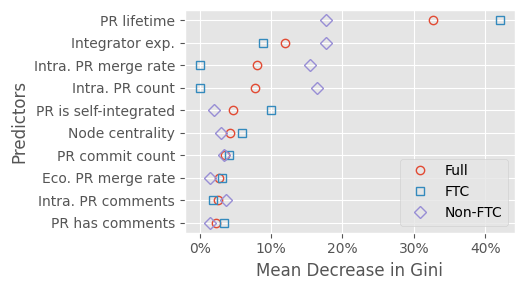

In [67]:
with plt.style.context('ggplot'):
    create_figure()

### Zoomed in / All features

output_path='/workspaces/msc_thesis/data//figures/feature_importance/importance_figure_0-35_xxx.png'


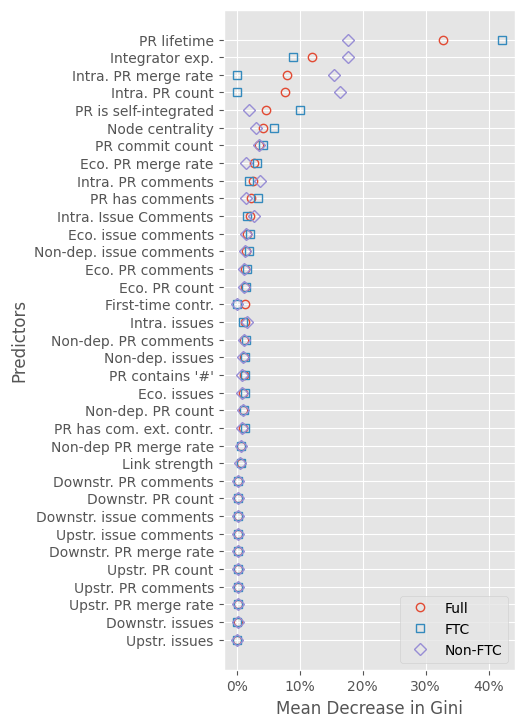

In [68]:
with plt.style.context('ggplot'):
    create_figure(entries_end=len(name_mapping))

output_path='/workspaces/msc_thesis/data//figures/feature_importance/importance_figure_10-25_xxx.png'


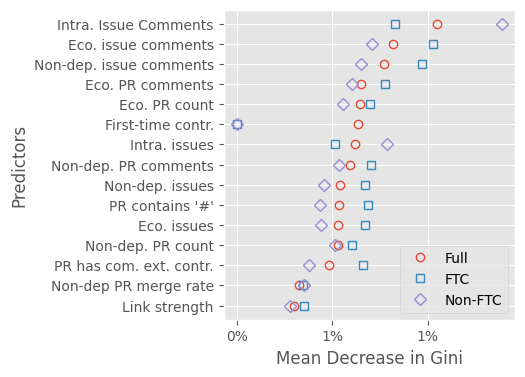

output_path='/workspaces/msc_thesis/data//figures/feature_importance/importance_figure_25-35_xxx.png'


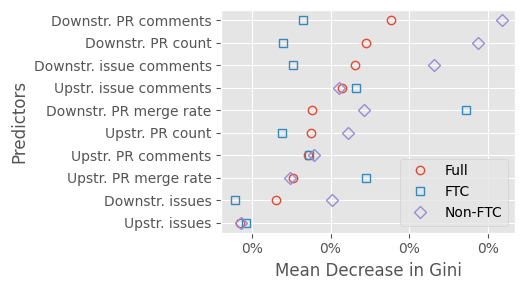

In [69]:
with plt.style.context("ggplot"):
    create_figure(entries_start=10, entries_end=25)
    create_figure(entries_start=25, entries_end=35)

### Separated Models

output_path='/workspaces/msc_thesis/data//figures/feature_importance/importance_figure_0-10_xoo.png'


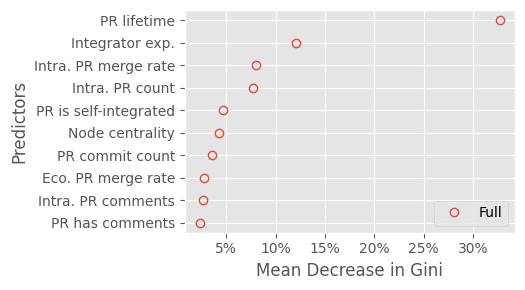

output_path='/workspaces/msc_thesis/data//figures/feature_importance/importance_figure_0-10_oxo.png'


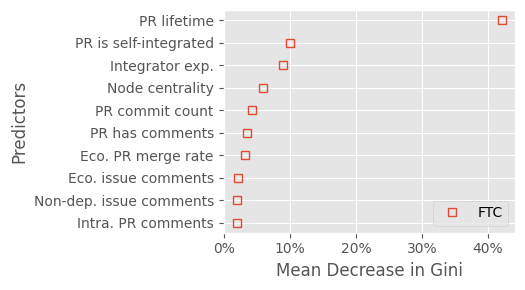

output_path='/workspaces/msc_thesis/data//figures/feature_importance/importance_figure_0-10_oox.png'


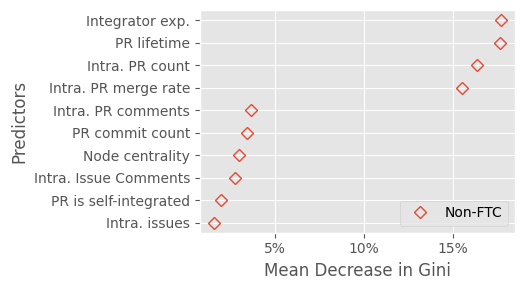

In [70]:
with plt.style.context("ggplot"):
    create_figure(plot_full=True, plot_ftc=False, plot_nftc=False)
    create_figure(plot_full=False, plot_ftc=True, plot_nftc=False)
    create_figure(plot_full=False, plot_ftc=False, plot_nftc=True)

In [71]:
import datetime

print(datetime.datetime.now())

2024-03-22 14:49:14.306473
